In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm

print(os.listdir())
import matplotlib.pyplot as plt

['graph_example275.jpg', 'graph_example300.jpg', 'graph_example100.jpg', 'social_graph_indicator.txt', '.DS_Store', 'social_A.txt', 'social_graph_labels.txt', 'graph_example0.jpg', 'graph_example175.jpg', 'social_to_adjacency.ipynb', 'graph_example375.jpg', 'graph_example200.jpg', 'graph_example75.jpg', 'social_node_labels.txt', 'large_twitch_edges.csv', 'graph_example50.jpg', 'graph_example225.jpg', 'graph_example350.jpg', 'social.txt', 'graph_example150.jpg', 'artist_edges.csv', '.ipynb_checkpoints', 'musae_facebook_edges.csv', 'graph_example125.jpg', 'graph_example325.jpg', 'sampling_test.ipynb', 'graph_example250.jpg', 'graph_example25.jpg']


In [2]:
social_data = pd.read_csv("musae_facebook_edges.csv")
print(social_data.shape)
np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")

(171002, 2)


In [3]:
G = nx.Graph()
for i in tqdm(range(social_data.shape[0])):
    G.add_edge(social_data.iloc[i, 0], social_data.iloc[i,1])
G = nx.convert_node_labels_to_integers(G)

100%|████████████████████████████████| 171002/171002 [00:02<00:00, 60191.84it/s]


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(171002, 2)
22470
200
160000


  0%|                                                   | 0/800 [00:00<?, ?it/s]

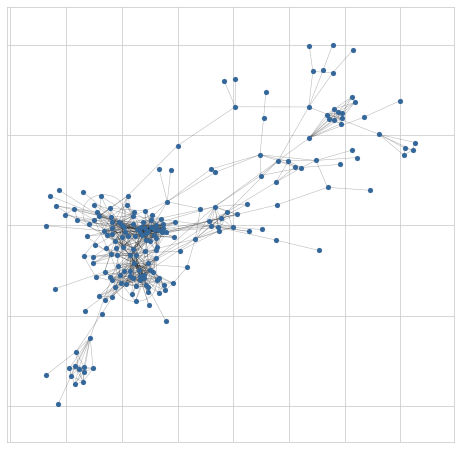

  2%|▋                                         | 13/800 [00:00<00:16, 48.89it/s]

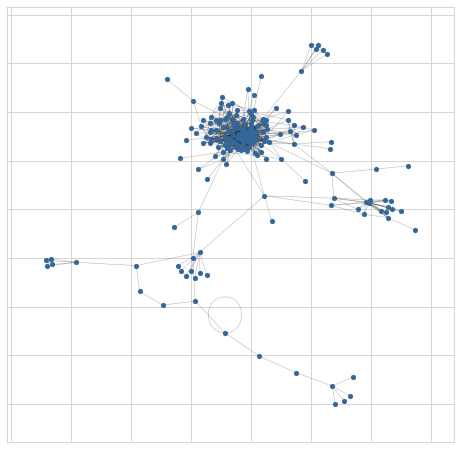

  6%|██▌                                       | 49/800 [00:00<00:09, 76.72it/s]

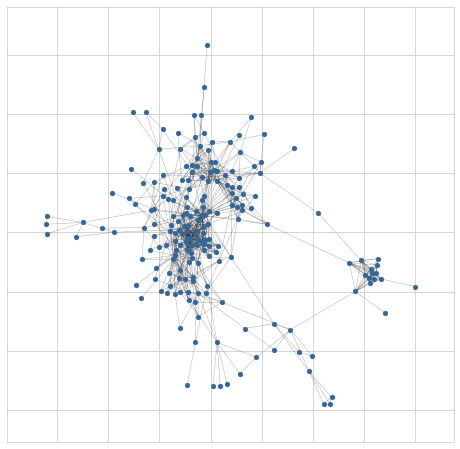

  9%|███▋                                      | 71/800 [00:01<00:10, 70.41it/s]

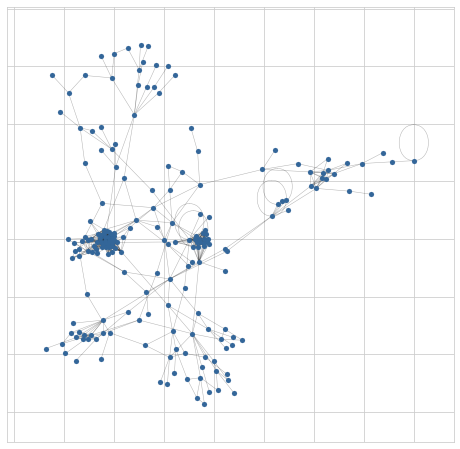

 11%|████▊                                     | 91/800 [00:01<00:10, 67.67it/s]

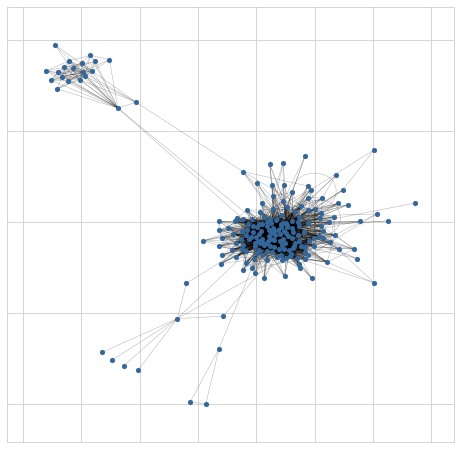

 16%|██████▎                                  | 124/800 [00:01<00:08, 75.41it/s]

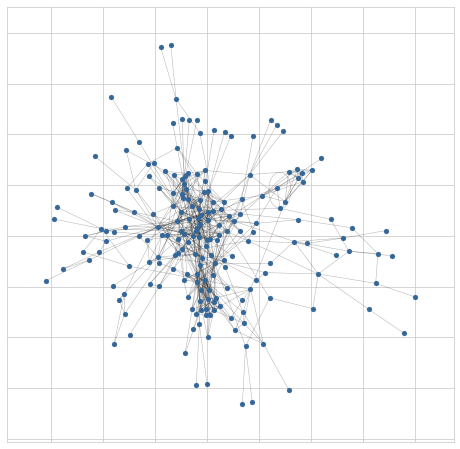

 18%|███████▍                                 | 146/800 [00:02<00:09, 72.00it/s]

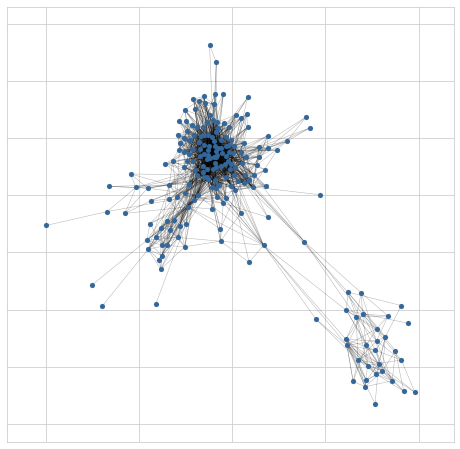

 21%|████████▌                                | 166/800 [00:02<00:09, 68.15it/s]

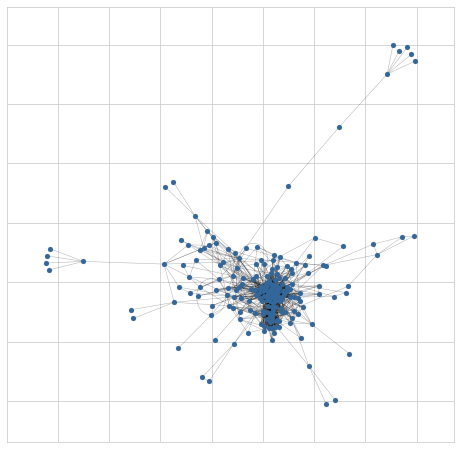

 25%|██████████                               | 197/800 [00:03<00:08, 74.92it/s]

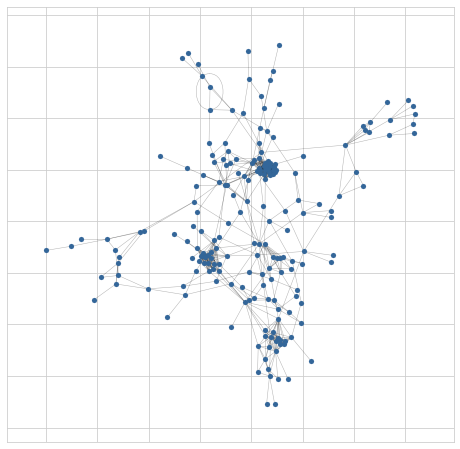

 27%|███████████                              | 216/800 [00:03<00:08, 68.94it/s]

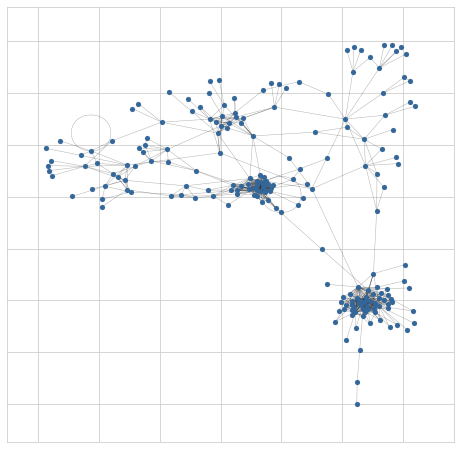

 30%|████████████▍                            | 243/800 [00:03<00:08, 66.71it/s]

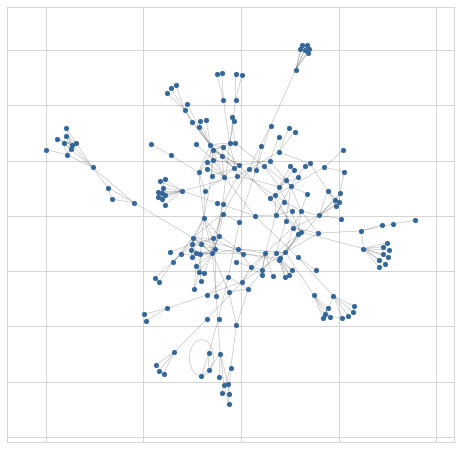

 34%|██████████████                           | 274/800 [00:04<00:06, 76.23it/s]

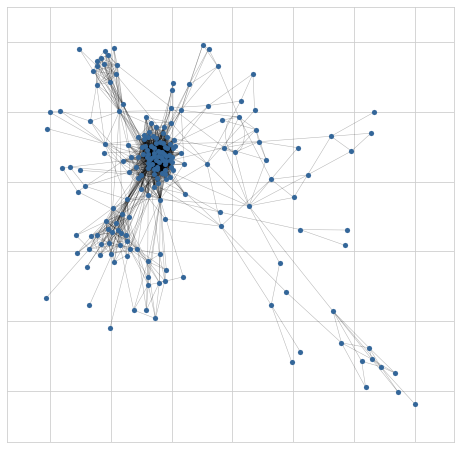

 37%|███████████████                          | 295/800 [00:04<00:07, 69.43it/s]

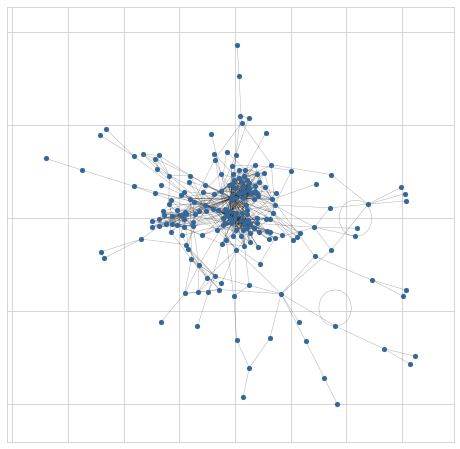

 39%|████████████████▏                        | 315/800 [00:05<00:07, 66.51it/s]

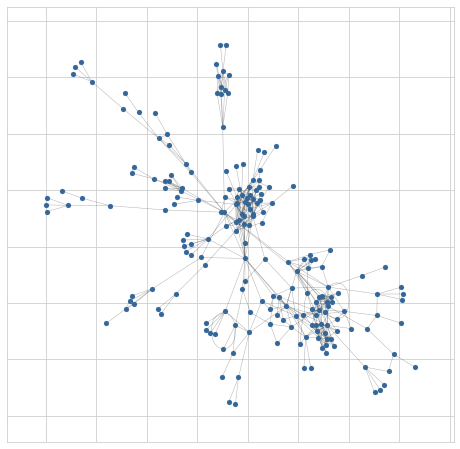

 44%|█████████████████▊                       | 348/800 [00:05<00:05, 76.06it/s]

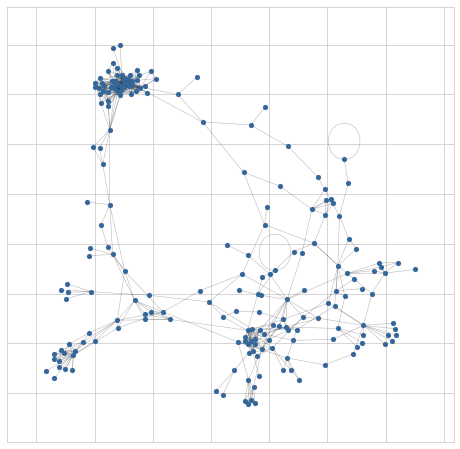

 46%|██████████████████▊                      | 368/800 [00:05<00:06, 69.85it/s]

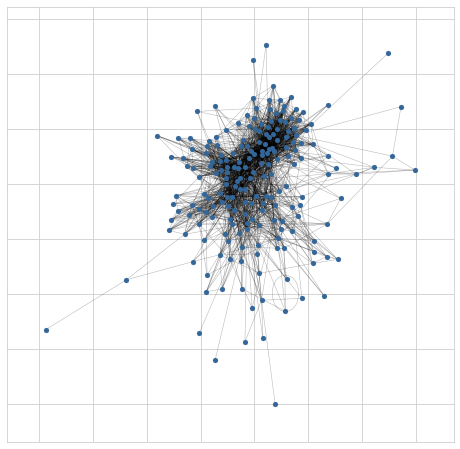

 50%|████████████████████▍                    | 399/800 [00:06<00:05, 72.15it/s]

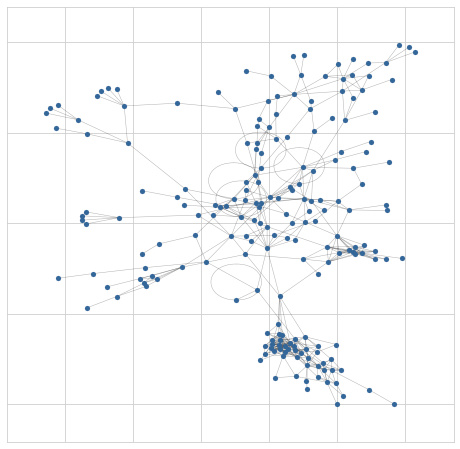

 52%|█████████████████████▍                   | 419/800 [00:06<00:05, 68.38it/s]

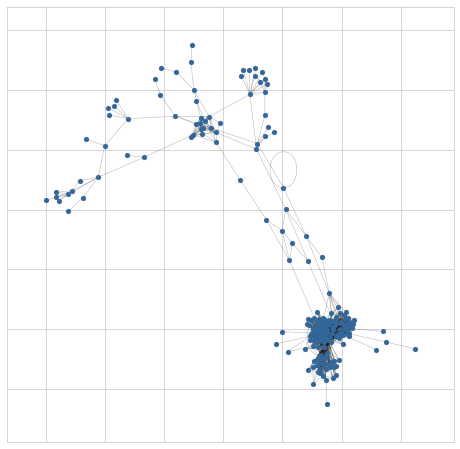

 56%|███████████████████████                  | 449/800 [00:07<00:04, 72.31it/s]

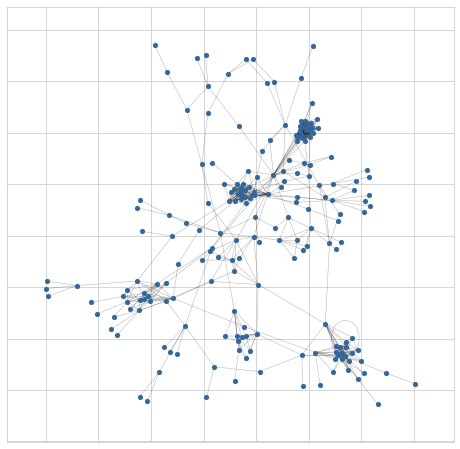

 58%|███████████████████████▉                 | 468/800 [00:07<00:04, 66.45it/s]

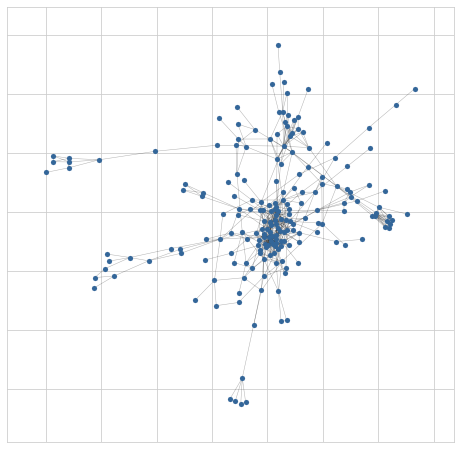

 62%|█████████████████████████▍               | 496/800 [00:07<00:04, 69.31it/s]

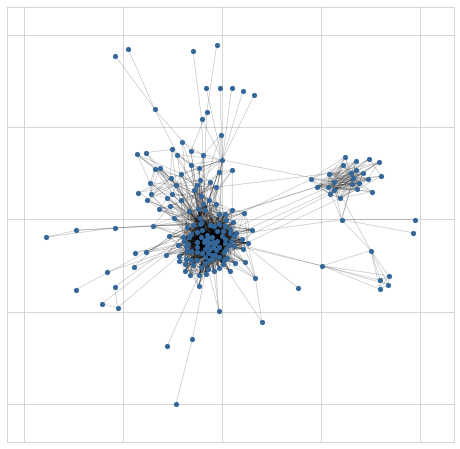

 66%|██████████████████████████▉              | 525/800 [00:08<00:03, 68.99it/s]

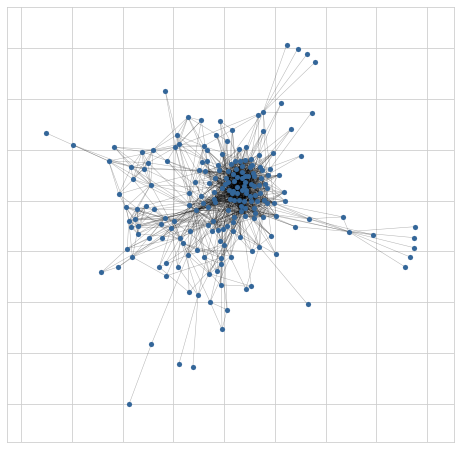

 68%|███████████████████████████▉             | 544/800 [00:08<00:04, 63.96it/s]

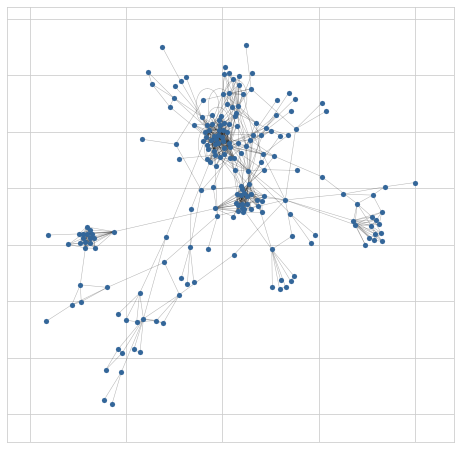

 71%|█████████████████████████████▎           | 571/800 [00:09<00:03, 66.34it/s]

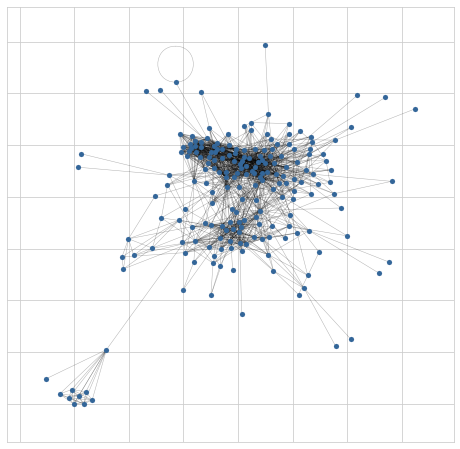

 75%|██████████████████████████████▋          | 598/800 [00:09<00:03, 65.36it/s]

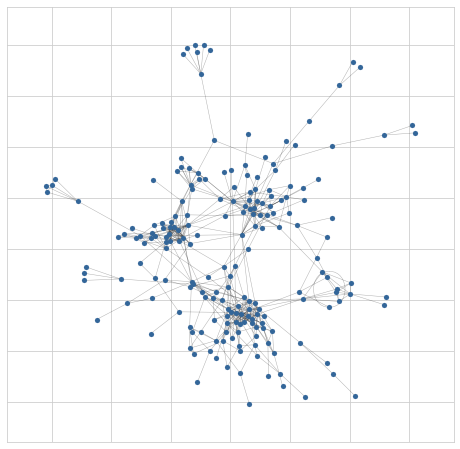

 77%|███████████████████████████████▌         | 615/800 [00:09<00:03, 60.87it/s]

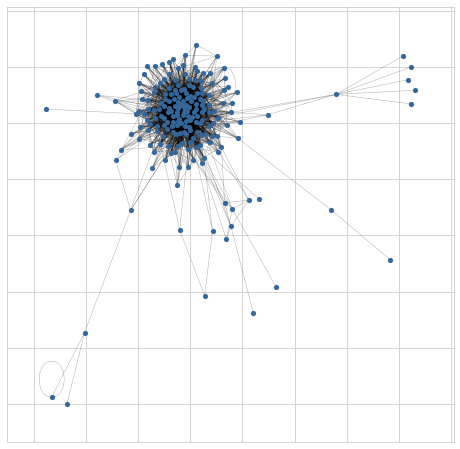

 81%|█████████████████████████████████        | 646/800 [00:10<00:02, 66.61it/s]

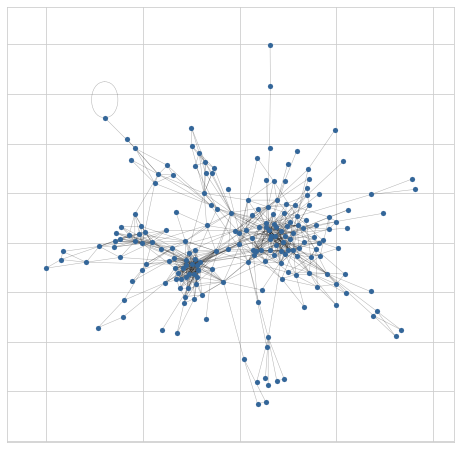

 84%|██████████████████████████████████▍      | 673/800 [00:10<00:01, 68.63it/s]

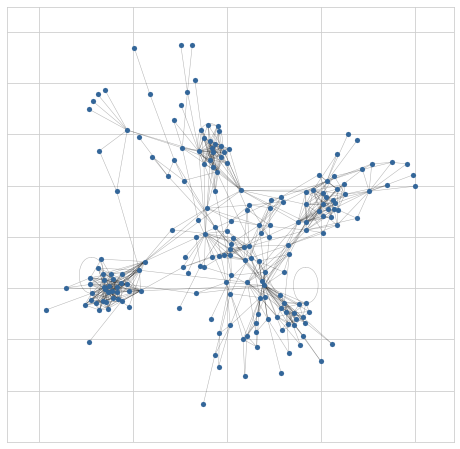

 88%|███████████████████████████████████▉     | 700/800 [00:11<00:01, 68.86it/s]

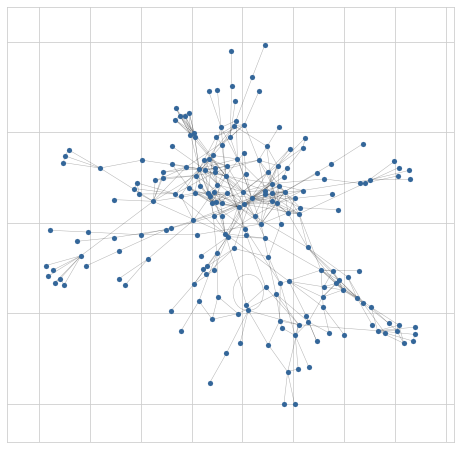

 90%|████████████████████████████████████▊    | 718/800 [00:11<00:01, 61.96it/s]

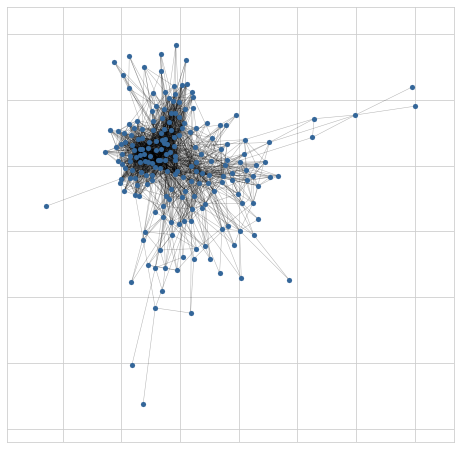

 94%|██████████████████████████████████████▍  | 750/800 [00:12<00:00, 63.61it/s]

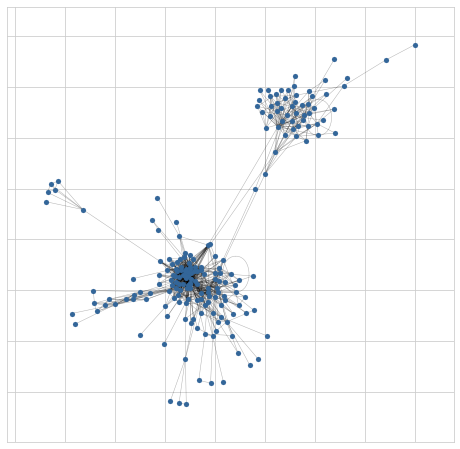

 96%|███████████████████████████████████████▎ | 767/800 [00:12<00:00, 57.54it/s]

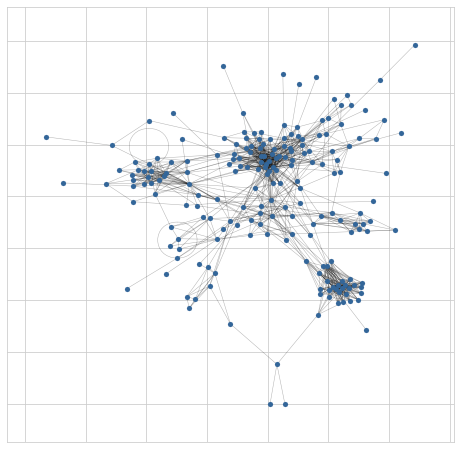

100%|█████████████████████████████████████████| 800/800 [00:13<00:00, 60.95it/s]


(963877, 2)
(160000,)
(160000,)
(160000,)


In [4]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 800

graph_ind_array = np.zeros(n_nodes)
n_per_graph = 200#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs

print(total_n)
graph_ind_array = np.zeros(total_n)


#number_of_nodes = int(0.5*graph.number_of_nodes())


for i in tqdm(range(n_graphs)):
    
    offset_index = i * n_per_graph
    sampler = ForestFireSampler(number_of_nodes = n_per_graph,#np.random.randint(, n_per_graph),
                               seed = np.random.randint(1, 1e6))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    nodes = list(new_graph.nodes())
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
        graph_ind_array = np.array(np.full(len(nodes), i+1))
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
        graph_ind_array = np.append(graph_ind_array, np.array(np.full(len(nodes), i+1)))
    
    if i % 25 == 0:
        plt.figure(figsize = (8,8))
        
        pos = nx.spring_layout(
          new_graph, k=0.1, iterations=100)
        
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=25,
          node_color='#336699',
          alpha=1,
          linewidths=0.2)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.3, width=0.5)

        plt.savefig(f"graph_example{i}.jpg")
        plt.show()

print(graph_adj.shape)
print(graph_ind_array.shape)

total_n = graph_ind_array.shape[0]


data_dir =        "/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/"

# for file in os.listdir(data_dir):
#     print(file)
#     if "DUMMY" in file:
#         shutil.rmtree(f"{data_dir}{file}")

np.savetxt(f'{data_dir}SOCIAL/social_A.txt', graph_adj, fmt='%d', delimiter=",\t")
np.savetxt(f'{data_dir}SOCIAL/social_graph_indicator.txt',graph_ind_array, fmt="%d")

np.savetxt(f'{data_dir}SOCIAL/social_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
print(np.arange(1, total_n+1).shape)

np.savetxt(f'{data_dir}SOCIAL/social_graph_labels.txt', np.ones(total_n), fmt = "%d")
print(np.ones(total_n).shape)


        
# np.savetxt(r'social_A.txt', graph_adj, fmt='%d', delimiter=",\t")
# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")

# np.savetxt(r'social_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
# print(np.arange(1, total_n+1).shape)

# np.savetxt(r'social_graph_labels.txt', np.ones(total_n), fmt = "%d")
# print(np.ones(total_n).shape)

In [5]:
# print(social_data.shape)
# n_nodes = np.unique(social_data.values).shape[0]
# print(n_nodes)
# n_graphs = 100

# graph_ind_array = np.zeros(n_nodes)
# n_per_graph = int(n_nodes / n_graphs)

# print(n_per_graph)

# G_ids = []

# for i in range(n_graphs):
    
#     G2 = nx.Graph()

#     for node in G.nodes():
        
#         neighbours = list(G.neighbors(node))


In [6]:


# # for i in range(n_graphs):
    
# #     graph_ind_array[i*n_per_graph : (i+1)*n_per_graph] = i+1
    
# #     if i == n_graphs - 1:
# #         graph_ind_array[(i+1)*n_per_graph:] = i+1

# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")
# print(graph_ind_array.shape)

In [7]:
# np.savetxt(r'social_node_labels.txt', np.arange(1, n_nodes+1), fmt = "%d")
# print(np.arange(1, n_nodes+1).shape)

In [8]:
# np.savetxt(r'social_graph_labels.txt', np.ones(n_nodes), fmt = "%d")
# print(np.ones(n_nodes).shape)

In [9]:
# adj = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_A.txt", delimiter = ",|\n")
# adj.shape

In [10]:
# g_ind = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_graph_indicator.txt", delimiter = ",|\n")
# g_ind.shape

In [11]:
# n_lab = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_node_labels.txt", delimiter = ",|\n")
# n_lab.shape